# CTIDE Studies

**Goal:** We kind of want to verify that these samples are doing something sensible, so I'm going to make some of the CTIDE specific plots to help us understand *where* the differences in these plots are coming from.

In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec

import numpy as np
import pandas as pd
import xarray as xr

import os
import sys
import h5py
sys.path.append("../..")
from root_to_np import getdR, passJet
from usefulFcts import VR, ftag_cone, getTrkMask, strToList
from trainNet import DIPS
from plottingFcts import trainingMetrics, sigBkgEff, getEffs, plotROCRatio, TProfile

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


**Loading in the data**

In [2]:
pdg_to_class = {0:0, 4:1, 5:2, 15:3}

nTrks = 60
dataDir = '../../data'
df_tag = '{}trks_sd0_rev'.format(nTrks)
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
dataTagTrain = '200ktrain_{}trks_{}_sd0_rev'.format(nTrks,vStr)

In [3]:
jdf = pd.read_hdf('{}/mu40_Topo_Zprime_5TeV_2lead_PT/files_60trks_sd0_rev/jet_500test_60trks_sd0_rev_000001.h5'.format(dataDir), key='jet_df')

In [4]:
jdf.columns

Index(['LabDr_HadF', 'pt_orig', 'eta_orig', 'phi_orig', 'm', 'ip3d_llr',
       'ip3d_pb', 'ip3d_pc', 'ip3d_pu', 'ip3d_ntrk', 'aliveAfterOR',
       'aliveAfterORmu', 'JVT', 'pt', 'eta', 'phi', 'nBHadr', 'nCHadr',
       'bH_pt', 'bH_eta', 'bH_Lxy', 'bH_dRjet', 'bH_PtTrk', 'bH_MTrk',
       'bH_nBtracks', 'bH_nCtracks', 'bH_nBtracks_400', 'bH_nCtracks_400',
       'vecSumTrkPt', 'avgmu', 'eventnb'],
      dtype='object')

In [3]:
masks = []
y_trks_list = []

jet_dfs = []
trk_xrs = []

for tag, nJetsTag in zip(['PT','NT','sctSplit','Bcut'],['200k','200k','200k','100k']):

    df_tag = '{}trks_sd0_rev'.format(nTrks)
    subDir = 'mu40_Topo_Zprime_5TeV_2lead_'+tag
    jdf = pd.read_hdf('{}/{}/jet_{}test_{}.h5'.format(dataDir,subDir,nJetsTag,df_tag), key='jet_df')
    txr = xr.open_dataarray('{}/{}/trk_{}test_{}.nc'.format(dataDir,subDir,nJetsTag,df_tag))
    
    X = txr.values
    y = jdf.LabDr_HadF.replace(pdg_to_class).values

    # Get the mask since all of the truth labels are track level variables
    y_trks = np.ones_like(X[:,:,0])
    y_trks = y_trks * y.reshape(-1,1)

    # This mask selects the non-masked tracks in the jet
    mask = getTrkMask(X)
    y_trks = y_trks[mask]
    
    '''
    Add new columns to the df for the amount of tracks of each type
    '''
    trk_origs = txr.loc[:,:,'orig'].values
    for o, orig_tag in zip([(0,1), 2, -1, 3], ['HF','frag','PU','GEANT']):

        if type(o) == tuple:
            orig_mask = np.zeros(nTrks, dtype=np.bool)
            for oi in o:
                orig_mask = orig_mask | (trk_origs == oi)

            # For this jet, I can't just *add* up the origin mask, b/c the b-jets have 
            # this variable assigned as the mask values
            # trkExists = (np.sum(X, axis=-1) != 0)
            
            orig_mask = orig_mask & mask # trkExists

        else:
            orig_mask = (trk_origs == o)

        key = 'ntrk_' + orig_tag
        jdf[key] = np.sum(orig_mask, axis=-1)
    
    '''
    I also want to see how the tracks evolve in the core and 
    periphery of the jet
    '''
    drs = txr.loc[:,:,'dr'].values
    
    jdf['ntrk_core'] = np.sum((drs < 0.02) & (drs != 0), axis=-1)
    jdf['ntrk_tail'] = np.sum(drs > 0.1,  axis=-1)
    jdf['ntrk_mid']  = np.sum((drs > 0.02) & (drs < 0.1),  axis=-1)
    
    # Also, can calculate this # w/o fakes
    noFakes = (trk_origs != -1)
    jdf['ntrk_core_noFakes'] = np.sum((drs < 0.02) & (drs != 0) & noFakes, axis=-1)
    jdf['ntrk_tail_noFakes'] = np.sum((drs > 0.1)  & noFakes, axis=-1)
    jdf['ntrk_mid_noFakes']  = np.sum((drs > 0.02) & (drs < 0.1) & noFakes,  axis=-1)
    
    jdf['ntrk_core_fakes'] = np.sum((drs < 0.02) & (drs != 0) & ~noFakes, axis=-1)
    jdf['ntrk_tail_fakes'] = np.sum((drs > 0.1)  & ~noFakes, axis=-1)
    jdf['ntrk_mid_fakes']  = np.sum((drs > 0.02) & (drs < 0.1) & ~noFakes,  axis=-1)
    
    HF = (trk_origs == 0) | (trk_origs == 1)
    jdf['ntrk_core_HF'] = np.sum((drs < 0.02) & (drs != 0) & HF, axis=-1)
    jdf['ntrk_tail_HF'] = np.sum((drs > 0.1)  & HF, axis=-1)
    jdf['ntrk_mid_HF']  = np.sum((drs > 0.02) & (drs < 0.1) & HF,  axis=-1)
    
    jdf['ntrk_HF'] = np.sum((drs != 0) & HF, axis=-1)
    jdf['ntrk_fakes'] = np.sum(~noFakes, axis=-1)
    
    jdf['r_track'] = 0.001* jdf['vecSumTrkPt'] / jdf['pt']
    
    masks.append(mask)
    y_trks_list.append(y_trks)
    
    jet_dfs.append(jdf)
    trk_xrs.append(txr)

    # Also include the scalar sum definition of r
    jdf['scalarSumTrkPt'] = np.sum(txr.loc[:,:,'pt'].values,axis=-1)
      
mask_PT, mask_NT, mask_sctSplit, mask_Bcut = masks
ytrks_PT, ytrks_NT, ytrks_sctSplit, ytrks_Bcut = y_trks_list   

jdf_PT, jdf_NT, jdf_sctSplit, mask_Bcut = jet_dfs
txr_PT, txr_NT, txr_sctSplit, mask_Bcut = trk_xrs

In [62]:
# plt.hist2d(jdf.pt,np.sum((drs != 0) & (trk_origs==0) | (trk_origs==1),axis=-1),100)
# plt.show()

## Step 1: Let's look at the charged to neutral energy fraction

$$\left< \frac{\sum p_T^{trk} }{ p_T^{jet} } \right>$$

We want to reproduce Fig 2a from ATL-PHYS-PUB-2017-016 to understand if the pseudo tracks better captures the charged energy component of the jet. 

<img src="../../figures/mu40_Topo_Zprime_5TeV_2lead_NT/ctide-pub-2017-016-fig2.png"
     style="size: 400px;" />
        
**Open questions:**
- Am I supposed to calculate the scalar or vector sum of the track $p_T$s? 

    PF said it makes more sense to use the vector sum, but that it shouldn't make a big difference, because for energetic jets, the tracks will be pretty collimated. But I thought for my own intuition building, I would do them *both* to understand *why* decisions were made.

In [4]:
figDir = "../../figures/mu40_Topo_Zprime_5TeV_2lead_Bcut/CTIDE/"

In [7]:
for c in jdf_NT.columns:
    print(c)

LabDr_HadF
pt_orig
eta_orig
phi_orig
m
ip3d_llr
ip3d_pb
ip3d_pc
ip3d_pu
ip3d_ntrk
aliveAfterOR
aliveAfterORmu
JVT
pt
eta
phi
nBHadr
nCHadr
bH_pt
bH_eta
bH_Lxy
bH_dRjet
bH_PtTrk
bH_MTrk
bH_nBtracks
bH_nCtracks
bH_nBtracks_400
bH_nCtracks_400
vecSumTrkPt
avgmu
eventnb
ntrk_HF
ntrk_frag
ntrk_PU
ntrk_GEANT
ntrk_core
ntrk_tail
ntrk_mid
ntrk_core_noFakes
ntrk_tail_noFakes
ntrk_mid_noFakes
scalarSumTrkPt


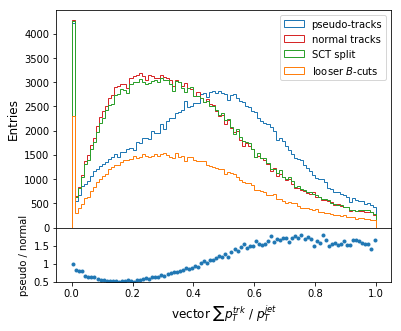

In [10]:
fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,0])
ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
fig.subplots_adjust(hspace=0)

ns = []

# xrange=(-0.5,60)
# nBins = int(xrange[1]-xrange[0])

colors = ['C0','C3','C2','C1']
labels = ['pseudo-tracks','normal tracks','SCT split','looser $B$-cuts']

for df, c, label in zip(jet_dfs, colors, labels):

    n, edg, _ = ax1.hist(0.001* df['vecSumTrkPt'] / df['pt'], 100,(0,1),
                         density=False,#log=True,
                         histtype='step',color=c,label=label)
    ns.append(n)

ax1.legend()
ax1.set_ylabel('Entries',fontsize=12)

ax2.plot(0.5 * (edg[:-1]+edg[1:]), ns[0] / ns[1],marker='.',linewidth=0)
ax2.set_xlabel('vector $\sum p_T^{trk}$ / $p_T^{jet}$',fontsize=12)
ax2.set_ylabel('pseudo / normal',fontsize=10)

yticks = [0.5,1,1.5]
ax2.set_yticks(yticks)
ax2.set_yticklabels([str(yi) for yi in yticks])

ax2.set_ylim(0.5,2)
# ax2.plot(xrange,[1]*2,'k--')

plt.show()

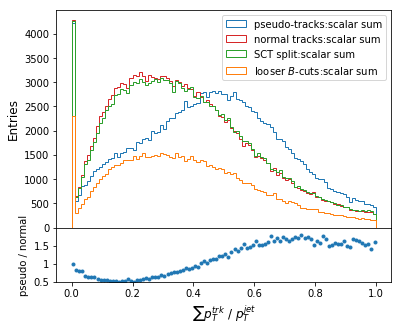

In [7]:
fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,0])
ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
fig.subplots_adjust(hspace=0)

ns = []

# xrange=(-0.5,60)
# nBins = int(xrange[1]-xrange[0])

for df, c, label in zip(jet_dfs, colors, labels):
    
    n, edg, _ = ax1.hist(df['scalarSumTrkPt'] / df['pt'], 100,(0,1),
                         density=False,#log=True,
                         histtype='step',color=c,label=label+':scalar sum')
    ns.append(n)

ax1.legend()
ax1.set_ylabel('Entries',fontsize=12)

ax2.plot(0.5 * (edg[:-1]+edg[1:]), ns[0] / ns[1],marker='.',linewidth=0)
ax2.set_xlabel('$\sum p_T^{trk}$ / $p_T^{jet}$',fontsize=12)
ax2.set_ylabel('pseudo / normal',fontsize=10)

yticks = [0.5,1,1.5]
ax2.set_yticks(yticks)
ax2.set_yticklabels([str(yi) for yi in yticks])

ax2.set_ylim(0.5,2)
# ax2.plot(xrange,[1]*2,'k--')

plt.show()

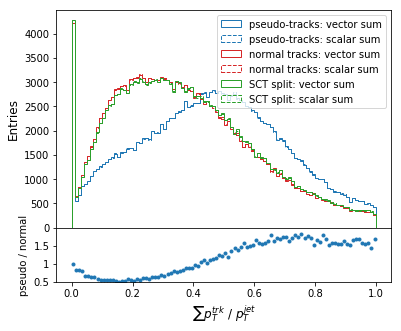

In [14]:
fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,0])
ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
fig.subplots_adjust(hspace=0)

ns = []

# xrange=(-0.5,60)
# nBins = int(xrange[1]-xrange[0])

for df, c, label in zip(jet_dfs, colors, labels):
    
    n, edg, _ = ax1.hist(0.001* df['vecSumTrkPt'] / df['pt'], 100,(0,1),
                         density=False,#log=True,
                         histtype='step',color=c,label=label+': vector sum')
    
    ns.append(n)
    
    n, edg, _ = ax1.hist(df['scalarSumTrkPt'] / df['pt'], 100,(0,1),
                         density=False,linestyle='--',#log=True,
                         histtype='step',color=c,label=label+': scalar sum')
    

ax1.legend()
ax1.set_ylabel('Entries',fontsize=12)

ax2.plot(0.5 * (edg[:-1]+edg[1:]), ns[0] / ns[1],marker='.',linewidth=0)
ax2.set_xlabel('$\sum p_T^{trk}$ / $p_T^{jet}$',fontsize=12)
ax2.set_ylabel('pseudo / normal',fontsize=10)

yticks = [0.5,1,1.5]
ax2.set_yticks(yticks)
ax2.set_yticklabels([str(yi) for yi in yticks])

ax2.set_ylim(0.5,2)
# ax2.plot(xrange,[1]*2,'k--')

plt.show()

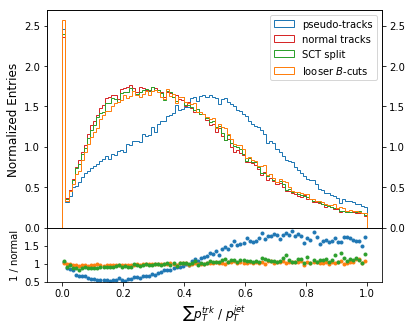

In [49]:
fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,0])
ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
fig.subplots_adjust(hspace=0)

ns = []

# xrange=(-0.5,60)
# nBins = int(xrange[1]-xrange[0])

for df, c, label in zip(jet_dfs, colors, labels):
    
    n, edg, _ = ax1.hist(df['r_track'], 100,(0,1),
                         density=True,#log=True,
                         histtype='step',color=c,label=label)
    ns.append(n)

ax1.legend()
ax1.set_ylabel('Normalized Entries',fontsize=12)

ax2.plot(0.5 * (edg[:-1]+edg[1:]), ns[0] / ns[1],marker='.',linewidth=0)
ax2.plot(0.5 * (edg[:-1]+edg[1:]), ns[2] / ns[1],marker='.',linewidth=0)
ax2.plot(0.5 * (edg[:-1]+edg[1:]), ns[3] / ns[1],marker='.',linewidth=0)

ax2.set_xlabel('$\sum p_T^{trk}$ / $p_T^{jet}$',fontsize=12)
ax2.set_ylabel('1 / normal',fontsize=10)

yticks = [0.5,1,1.5]
ax2.set_yticks(yticks)
ax2.set_yticklabels([str(yi) for yi in yticks])

ax2.set_ylim(0.5,2)

'''
Add a scale on the RHS
'''
ax3 = ax1.twinx()
ax3.set_ylim(ax1.get_ylim())


plt.savefig("{}/rtrack_norm.pdf".format(figDir),bbox_inches='tight')

plt.show()

Ok, this is *great* to know overall! So, I think the conclusions here are:
- The pseudo tracks are better capturing the charged energy of the jet  
- Since this sample has a lot of high $p_T$ jets, the decay products are pretty collimated, so (at least in the overall distribution) I'm *not* seeing an overall difference for the scalar versus vector sum of the tracks

Since PF told me to use the vector sum for this variable, I'm going to use the vector sum, but I think it's also good to have an understanding of *why*.


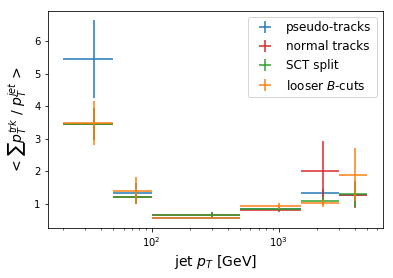

In [8]:
pT_edges = np.array([20, 50, 100,500,1500,3000,5000])

pT_mid = 0.5 * (pT_edges[1:] + pT_edges[:-1])
pT_width = 0.5 * (pT_edges[1:] - pT_edges[:-1])

for df, c, label in zip(jet_dfs, colors, labels):
    
    mu, mu_err = TProfile(df['pt'], df['r_track'], pT_edges)

    plt.errorbar(pT_mid, mu, mu_err, pT_width, 
                 linewidth=0,elinewidth=1.5,
                 label=label, color=c)

plt.legend(fontsize=12)
plt.xlabel('jet $p_T$ [GeV]', fontsize=14)
plt.ylabel('< $\sum p_T^{trk}$ / $p_T^{jet}$ >', fontsize=14)

# Also... add the locations for the pixel layers on the figure
plt.xscale('log')

plt.savefig("{}/r_track_vs_jpt.pdf".format(figDir),bbox_inches='tight')

plt.show()
#break

In [13]:
err

[0.00619357418624906,
 0.005531926526852151,
 0.0020287281170202533,
 0.0010000769902338167,
 0.000896201319381617,
 0.0013010370231700237]

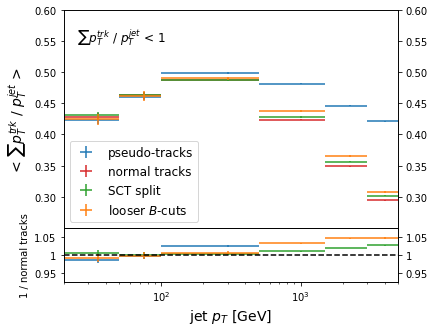

In [39]:
pT_edges = np.array([20, 50, 100,500,1500,3000,5000])

pT_mid = 0.5 * (pT_edges[1:] + pT_edges[:-1])
pT_width = 0.5 * (pT_edges[1:] - pT_edges[:-1])

fig = plt.figure(figsize=(6,5))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,0])
ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
fig.subplots_adjust(hspace=0)

#for jdf, trkCollection, c in zip(jet_dfs, ['pseudo','normal'], ['C0','C3']):
ns,errs = [],[]
for df, c, label in zip(jet_dfs, colors, labels):
    
    mu, mu_err = TProfile(df['pt'], df['r_track'], pT_edges, (df['r_track'] < 1))

    ax1.errorbar(pT_mid, mu, mu_err, pT_width, 
                 linewidth=0,elinewidth=1.5,
                 label=label, color=c)

    ns.append(mu)
    errs.append(mu_err)
    
ax1.legend(fontsize=12)
ax1.set_xlabel('jet $p_T$ [GeV]', fontsize=14)
ax1.set_ylabel('< $\sum p_T^{trk}$ / $p_T^{jet}$ >', fontsize=14)

ax1.text(25,0.55,'$\sum p_T^{trk}$ / $p_T^{jet}$ < 1',fontsize=12)


'''
PF was also telling me that it would be nice to make a ratio plot below w/r.t. NT
'''
i_NT = 1
for i,(n,err,c) in enumerate(zip(ns,errs,colors)):
    if i == i_NT:
        continue
        
    ax2.errorbar(pT_mid, n/ns[i_NT], np.sqrt(err**2 + errs[i_NT]**2),pT_width,
                 linewidth=0,elinewidth=1.5, color=c)

#ax4.plot(ax4.get_xlim(),[1]*2,'k--')
ax2.plot([pT_edges[0],pT_edges[-1]],[1]*2,'k--')
# ax2.set_xlim(xlim)
ax2.set_ylabel('1 / normal tracks')

# Add a new y-axis label on the RHS
ax3 = ax1.twinx()
ylim1 = (0.25,0.6)
yticks1 = [0.3,0.35,0.4,0.45,0.5,0.55,0.6]
for ax in [ax1, ax3]:
    ax.set_ylim(ylim1)
    ax.set_yticks(yticks1)
    ax.set_yticklabels(["{:.2f}".format(yi) for yi in yticks1])


ax4 = ax2.twinx()
ylim2 = (0.925,1.075)
yticks2 = [0.95,1,1.05]

for ax in [ax2, ax4]:
    ax.set_ylim(ylim2)
    ax.set_yticks(yticks2)
    ax.set_yticklabels([str(yi) for yi in yticks2])
    
# Also... add the locations for the pixel layers on the figure
plt.xscale('log')
plt.xlim(pT_edges[0],pT_edges[-1])
ax2.set_xlabel('jet $p_T$ [GeV]',fontsize=14)

plt.savefig("{}/rtrack_vs_jpt_rtrack<1.pdf".format(figDir),bbox_inches='tight')

plt.show()
#break

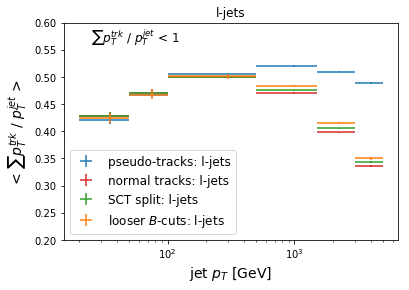

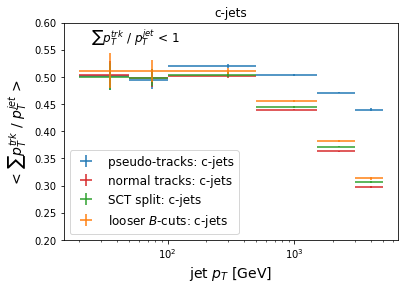

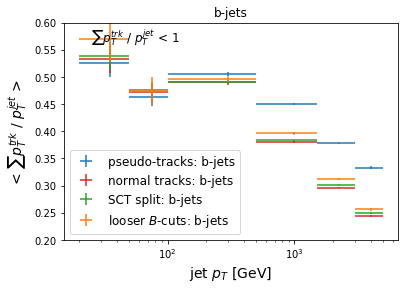

In [50]:
for pdg, flav in zip([0,4,5],['l','c','b']): #,['C0','C1','C2']):

    plt.figure()
    
    #for jdf, trkCollection, c, tag in zip(jet_dfs, ['pseudo','normal'], ['C0','C3'], ['PT','NT']):
    for df, c, label in zip(jet_dfs, colors, labels):
        
            mask = (df['r_track'] < 1) & (df['LabDr_HadF'] == pdg)
            mu, mu_err = TProfile(df['pt'], df['r_track'], pT_edges, mask)

            plt.errorbar(pT_mid, mu, mu_err, pT_width, 
                         linewidth=0,elinewidth=1.5,#fmt=m,
                         label='{}: {}-jets'.format(label,flav), color=c)

    plt.legend(fontsize=12, loc='lower left')#,bbox_to_anchor=(1,1.05))
    plt.xlabel('jet $p_T$ [GeV]', fontsize=14)
    plt.ylabel('< $\sum p_T^{trk}$ / $p_T^{jet}$ >', fontsize=14)
    plt.title(flav + '-jets')
    
    plt.text(25,0.565,'$\sum p_T^{trk}$ / $p_T^{jet}$ < 1',fontsize=12)
    plt.ylim(0.2,0.6)

    # Also... add the locations for the pixel layers on the figure
    plt.xscale('log')
    #plt.savefig("../../figures/mu40_Topo_Zprime_5TeV_2lead_{}/CTIDE/rtrack_vs_jpt_rtrack<1_flav.pdf".format(tag),bbox_inches='tight')

    plt.show()
    

In [16]:
# var_tags = ['r_track']

# mus = {k:[] for k in var_tags}
# sds = {k:[] for k in var_tags}

# start, stop, step = 20, 5e3, 480 
# pT_edges = np.arange(start, stop+step, step)
# mid_pt = (pT_edges[1:]+pT_edges[:-1]) / 2

# nEdgs = pT_edges.shape[0]

# for jdf, title in zip(jet_dfs,['pseudo tracks','normal tracks']):
    
#     indices = np.digitize(jdf['pt'], pT_edges)
#     plt.figure()
#     for pdg, flav, c in zip([0,4,5],['l','c','b'],['C0','C1','C2']):
#         for key in var_tags:

#             mus['r_track'].append([jdf.loc[(indices==i)&(jdf['LabDr_HadF']==pdg),key].mean() for i in range(1,nEdgs)])
#             sds['r_track'].append([jdf.loc[(indices==i)&(jdf['LabDr_HadF']==pdg),key].std()  for i in range(1,nEdgs)])

#         plt.errorbar(mid_pt, mus['r_track'][-1],  sds['r_track'][-1],   
#                      markersize=10,#sds['r_track'][-1], 
#                      label=flav+"-jets: "+title,  
#                      color=c,alpha=0.5)

#     plt.xlim(start,stop)
#     plt.xlabel('jet $p_T$ [GeV]', fontsize = 14)
#     plt.ylabel('<$\Sigma$ trk $p_T$ / jet $p_T$ >', fontsize = 14)
#     plt.legend(loc='upper left',fontsize=14)
#     #plt.title(title,fontsize=16)
#     plt.ylim(0,3)
    
#     #plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/nTrks_HF_frag.pdf'.format(figDir))
#     plt.show()


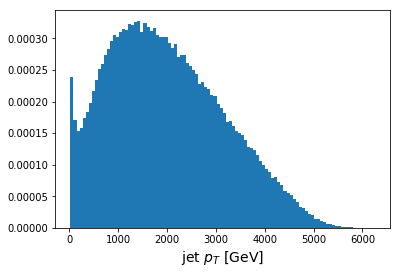

In [28]:
#for jdf, label in zip(jet_dfs,['pseudo tracks','normal tracks']):
    
plt.hist(jdf['pt'],100,label=label,density=True)

plt.xlabel('jet $p_T$ [GeV]', fontsize = 14)
plt.show()

In [29]:
var_tags = ['r_track']

mus = {k:[] for k in var_tags}
sds = {k:[] for k in var_tags}

start, stop, step = 20, 5e3, 480 
pT_edges = np.arange(start, stop+step, step)
mid_pt = (pT_edges[1:]+pT_edges[:-1]) / 2

nEdgs = pT_edges.shape[0]

In [19]:
# for jdf, title in zip(jet_dfs,['pseudo tracks','normal tracks']):
    
#     indices = np.digitize(jdf['pt'], pT_edges)
#     plt.figure()
#     for pdg, flav, c in zip([0,4,5],['l','c','b'],['C0','C1','C2']):
#         for key in var_tags:

#             mus['r_track'].append([jdf.loc[(indices==i)&(jdf['LabDr_HadF']==pdg),key].mean() for i in range(1,nEdgs)])
#             sds['r_track'].append([jdf.loc[(indices==i)&(jdf['LabDr_HadF']==pdg),key].std()  for i in range(1,nEdgs)])

#         #plt.figure()
# #         plt.plot(mid_pt, mus['r_track'][-1], marker='.',linewidth=0, 
# #                  markersize=10,#sds['r_track'][-1], 
# #                  label=flav+"-jets: "+title,  
# #                  color=c,alpha=0.5)

#         plt.errorbar(mid_pt, mus['r_track'][-1],  sds['r_track'][-1],   
#                      markersize=10,#sds['r_track'][-1], 
#                      label=flav+"-jets: "+title,  
#                      color=c,alpha=0.5)

# #         plt.plot(mid_pt, mus['r_track'][-1], marker='.',linewidth=0, 
# #                  markersize=10,#sds['r_track'][-1], 
# #                  label=flav+"-jets: "+title,  
# #                  color=c,alpha=0.5)

#     plt.xlim(start,stop)
#     plt.xlabel('jet $p_T$ [GeV]', fontsize = 14)
#     plt.ylabel('<$\Sigma$ trk $p_T$ / jet $p_T$ >', fontsize = 14)
#     plt.legend(loc='upper left',fontsize=14)
#     #plt.title(title,fontsize=16)
#     plt.ylim(0,3)
    
#     #plt.savefig('{}/mc16d_PFlow_Zprime_5TeV/nTrks_HF_frag.pdf'.format(figDir))
#     plt.show()



**Conclusion:** We really don't have high enough stats to draw any conclusions from this profile plot.

**# tracks vs jet $p_T$**

Why is this interesting?

More energetic jets are going to have denser cores, so it will be super intereresting to see how the # of tracks evolves with the jet $p_T$.

I think it would also be cool to see how this evolves for the different flavors of jets too!

In [6]:
pT_edges = np.array([20,60,100,200,400,600,1000,1500,2000,3000,5000])

pT_mid = 0.5 * (pT_edges[1:] + pT_edges[:-1])
pT_width = 0.5 * (pT_edges[1:] - pT_edges[:-1])

In [47]:
yvars = ['ip3d_ntrk','ntrk_core','ntrk_mid','ntrk_tail',
         'ntrk_core_noFakes','ntrk_mid_noFakes','ntrk_tail_noFakes',
         'ntrk_core_fakes','ntrk_tail_fakes','ntrk_mid_fakes',
         'ntrk_core_HF','ntrk_tail_HF','ntrk_mid_HF',
         'ntrk_HF','ntrk_fakes'
        ]

ylabels = ['# ip3d tracks',
           '$n_{trk}$($\Delta R < 0.02$)',
           '$n_{trk}(0.02 < \Delta R < 0.1)$',
           '$n_{trk}(\Delta R > 0.1)$',
           '$n_{trk}(\Delta R < 0.02 & P_{match} > 0.75)$',
           '$n_{trk}(0.02 < \Delta R < 0.1 & P_{match} > 0.75)$',
           '$n_{trk}(\Delta R > 0.1 & P_{match} > 0.75)$',
           '$n_{trk}(\Delta R < 0.02 & P_{match} < 0.75)$',
           '$n_{trk}(0.02 < \Delta R < 0.1 & P_{match} < 0.75)$',
           '$n_{trk}(\Delta R > 0.1 & P_{match} < 0.75)$',          
           'HF $n_{trk}(\Delta R < 0.02)$',
           'HF $n_{trk}(0.02 < \Delta R < 0.1)$',
           'HF $n_{trk}(\Delta R > 0.1)$',
           'HF $n_{trk}$',
           r'$n_trk(P_{match}$ < 0.75 or $\nexists$ truth link)',
          ]

In [51]:
len(ylabels)

15

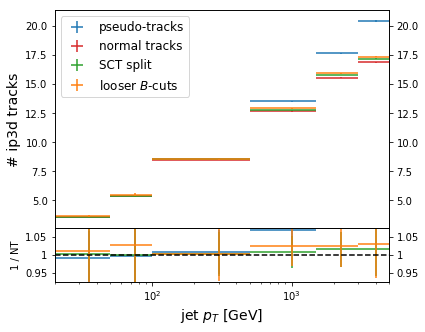

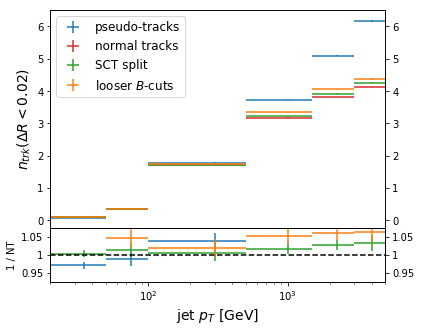

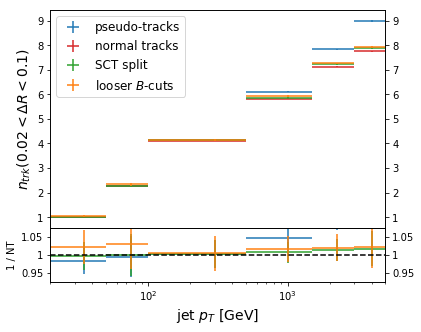

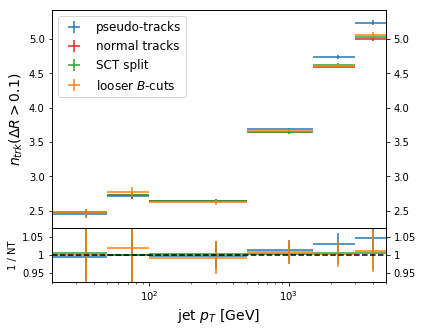

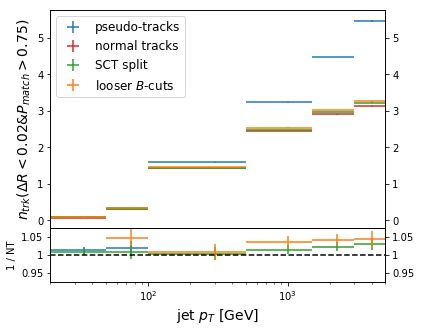

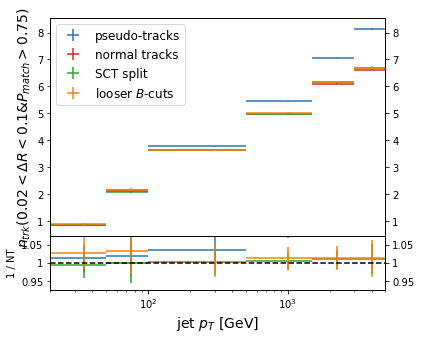

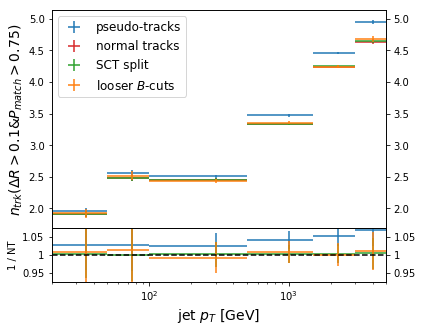

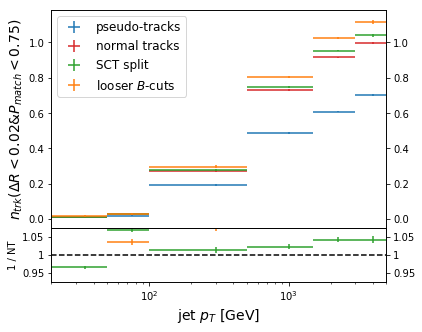

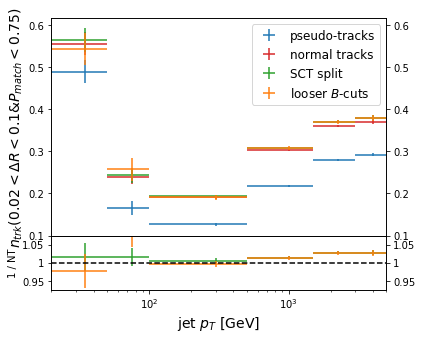

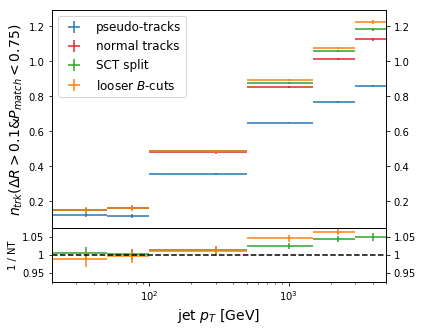

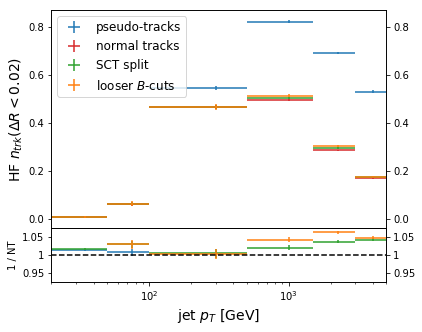

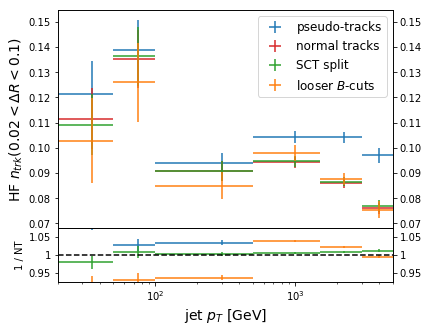

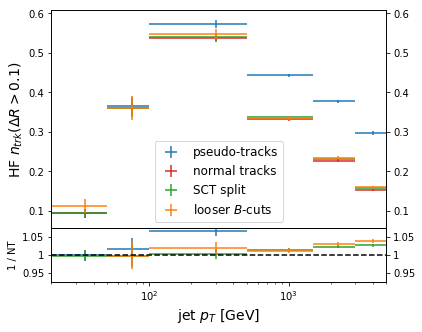

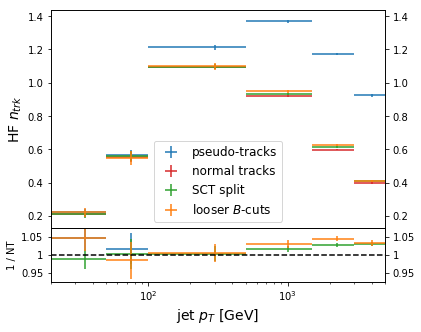

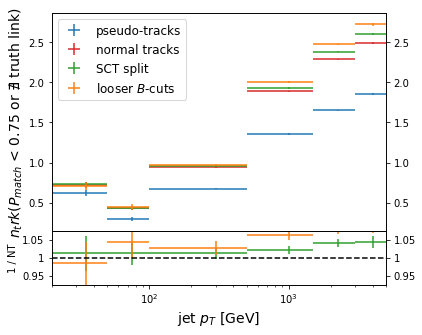

In [48]:
for yvar, ylabel in zip(yvars,ylabels):
    
    fig = plt.figure(figsize=(6,5))
    gs = gridspec.GridSpec(5,1)
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
    fig.subplots_adjust(hspace=0)

    ns,errs = [],[]
    for df, c, label in zip(jet_dfs, colors, labels):

        mu, mu_err = TProfile(df['pt'], df[yvar], pT_edges)

        ax1.errorbar(pT_mid, mu, mu_err, pT_width, 
                     linewidth=0,elinewidth=1.5,
                     label=label, color=c)

        ns.append(mu)
        errs.append(mu_err)

    ax1.legend(fontsize=12)
    ax1.set_xlabel('jet $p_T$ [GeV]')#, fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)

    i_NT = 1
    for i,(n,err,c) in enumerate(zip(ns,errs,colors)):
        if i == i_NT:
            continue

        ax2.errorbar(pT_mid, n/ns[i_NT], np.sqrt(err**2 + errs[i_NT]**2),pT_width,
                     linewidth=0,elinewidth=1.5, color=c)

    ax2.plot([pT_edges[0],pT_edges[-1]],[1]*2,'k--')
    ax2.set_ylabel('1 / NT')

    # Add a new y-axis label on the RHS
    ax3 = ax1.twinx()
    ylim1 = ax1.get_ylim()
    yticks1 = ax1.get_yticks()
    ax3.set_yticks(yticks1[1:-1])
    ax3.set_ylim(ylim1)
    
    ax4 = ax2.twinx()
    ylim2 = (0.925,1.075)
    yticks2 = [0.95,1,1.05]

    for ax in [ax2, ax4]:
        ax.set_ylim(ylim2)
        ax.set_yticks(yticks2)
        ax.set_yticklabels([str(yi) for yi in yticks2])

    # Also... add the locations for the pixel layers on the figure
    plt.xscale('log')
    plt.xlim(pT_edges[0],pT_edges[-1])
    ax2.set_xlabel('jet $p_T$ [GeV]',fontsize=14)
    plt.savefig('{}/{}_vs_jpt.pdf'.format(figDir,yvar),bbox_inches='tight')
    
    plt.show()
    #break

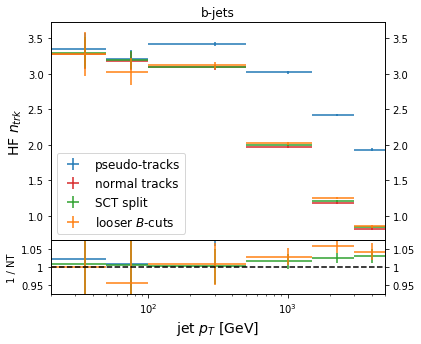

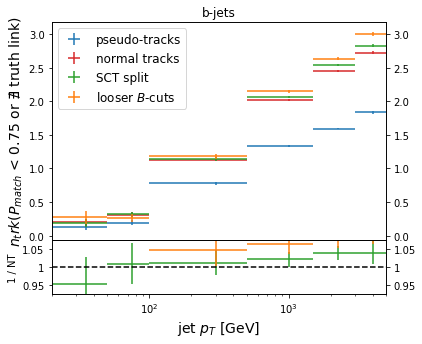

In [67]:
for yvar, ylabel in zip(yvars[-2:],ylabels[-2:]):
    
    fig = plt.figure(figsize=(6,5))
    gs = gridspec.GridSpec(5,1)
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4:,0],sharex=ax1)
    fig.subplots_adjust(hspace=0)

    ns,errs = [],[]
    for df, c, label in zip(jet_dfs, colors, labels):

        mu, mu_err = TProfile(df['pt'], df[yvar], pT_edges, (df.LabDr_HadF == 5))

        ax1.errorbar(pT_mid, mu, mu_err, pT_width, 
                     linewidth=0,elinewidth=1.5,
                     label=label, color=c)

        ns.append(mu)
        errs.append(mu_err)

    ax1.legend(fontsize=12)
    ax1.set_xlabel('jet $p_T$ [GeV]')#, fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)

    i_NT = 1
    for i,(n,err,c) in enumerate(zip(ns,errs,colors)):
        if i == i_NT:
            continue

        ax2.errorbar(pT_mid, n/ns[i_NT], np.sqrt(err**2 + errs[i_NT]**2),pT_width,
                     linewidth=0,elinewidth=1.5, color=c)

    ax2.plot([pT_edges[0],pT_edges[-1]],[1]*2,'k--')
    ax2.set_ylabel('1 / NT')

    # Add a new y-axis label on the RHS
    ax3 = ax1.twinx()
    ylim1 = ax1.get_ylim()
    yticks1 = ax1.get_yticks()
    ax3.set_yticks(yticks1[1:-1])
    ax3.set_ylim(ylim1)
    
    ax4 = ax2.twinx()
    ylim2 = (0.925,1.075)
    yticks2 = [0.95,1,1.05]

    for ax in [ax2, ax4]:
        ax.set_ylim(ylim2)
        ax.set_yticks(yticks2)
        ax.set_yticklabels([str(yi) for yi in yticks2])

    # Also... add the locations for the pixel layers on the figure
    plt.xscale('log')
    plt.xlim(pT_edges[0],pT_edges[-1])
    ax2.set_xlabel('jet $p_T$ [GeV]',fontsize=14)
    ax1.set_title('b-jets')
    plt.savefig('{}/bjets/{}_vs_jpt.pdf'.format(figDir[:-6],yvar),bbox_inches='tight')
    
    plt.show()
    #break

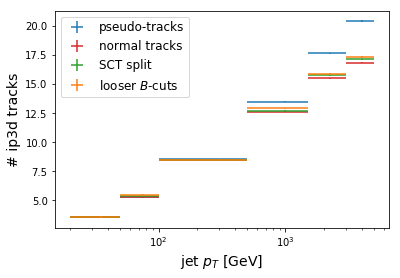

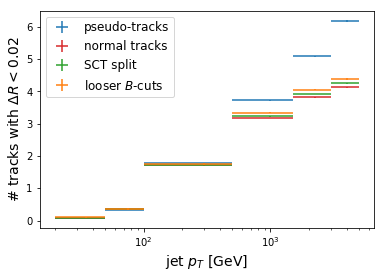

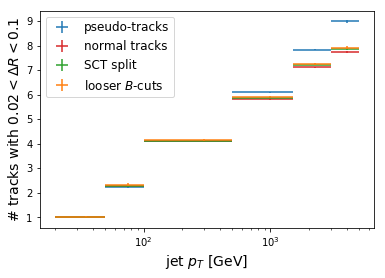

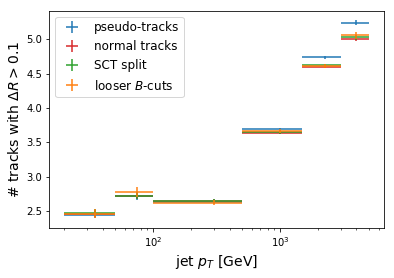

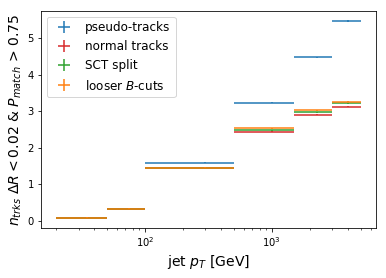

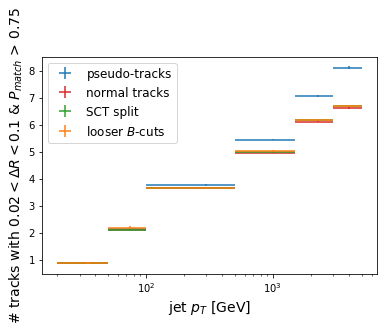

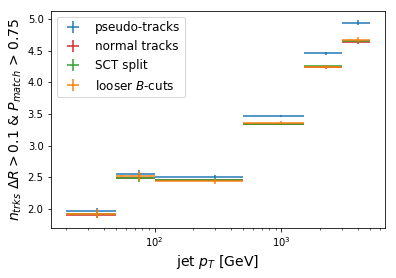

In [13]:
for yvar, ylabel in zip(yvars,ylabels):
    
    plt.figure()

    #for jdf, trkCollection, c in zip(jet_dfs, ['pseudo','normal'], ['C0','C3']):
    for df, c, label in zip(jet_dfs, colors, labels):
        
        # Maybe later I can break this down by jet flavor... but not now!
        mu, mu_err = TProfile(df['pt'], df[yvar], pT_edges)

        plt.errorbar(pT_mid, mu, mu_err, pT_width, 
                     linewidth=0,elinewidth=1.5,
                     label=label, color=c)

    plt.legend(fontsize=12)
    plt.xlabel('jet $p_T$ [GeV]', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # Also... add the locations for the pixel layers on the figure
    plt.xscale('log')

    plt.savefig('{}/{}_vs_jpt.pdf'.format(figDir,yvar),bbox_inches='tight')

plt.show()
#break

Hmmmm... could this be a feature of the track selectors?? I *don't* understand why we have more normal tracks in the core of the jet at high $p_T$.

Something that was completely unexpected that I have no idea why is why in the core of the jet, I'm having a better efficiency for normal tracks than pseudo tracks at high jet $p_T$.

In the periphery of the jet, I'm seeing a better efficiency for pseudo tracks.


I think it will also be interesting to probe this for the various jet flavors!!

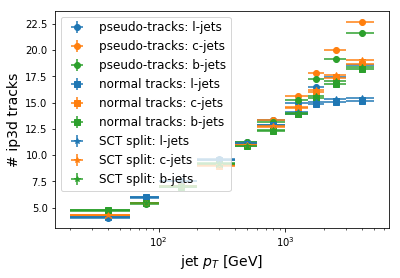

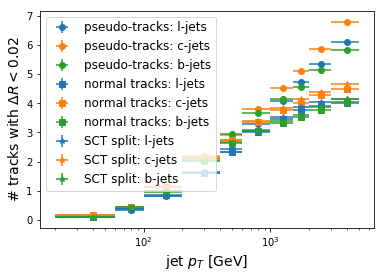

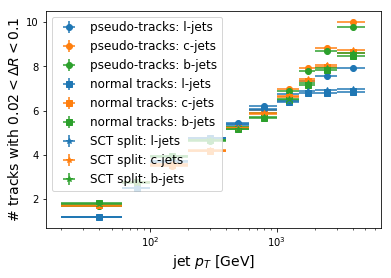

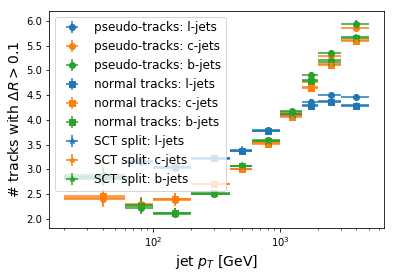

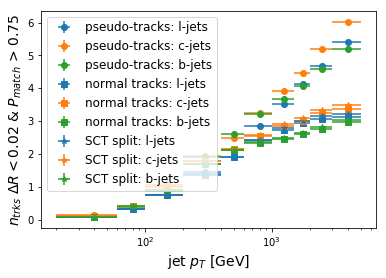

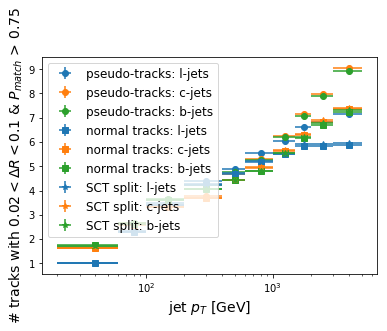

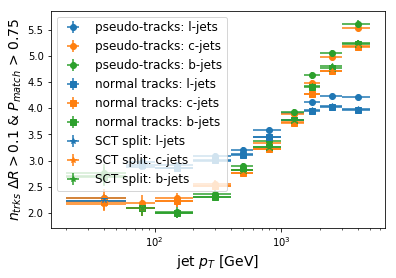

In [35]:
for yvar, ylabel in zip(yvars,ylabels):
    
    plt.figure()

    #for jdf, trkCollection, m in zip(jet_dfs, ['pseudo','normal'], ['o','s']):
    #for df, label, m in zip([jdf_PT,jdf_NT,jdf_sctSplit],['pseudo-tracks','normal tracks','SCT split'],):
    for df, c, label, m in zip(jet_dfs, colors, labels,['o','s','*','<']):

        # Maybe later I can break this down by jet flavor... but not now!
        for pdg, flav, c in zip([0,4,5],['l','c','b'],['C0','C1','C2']):
        
            mu, mu_err = TProfile(df['pt'], df[yvar], pT_edges, (df['LabDr_HadF'] == pdg))

            plt.errorbar(pT_mid, mu, mu_err, pT_width, 
                         linewidth=0,elinewidth=1.5,fmt=m,
                         label='{}: {}-jets'.format(label,flav), color=c)

    plt.legend(fontsize=12)
    plt.xlabel('jet $p_T$ [GeV]', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # Also... add the locations for the pixel layers on the figure
    plt.xscale('log')

    plt.savefig('{}/{}_vs_jpt_flav.pdf'.format(figDir,yvar),bbox_inches='tight')
    
plt.show()
#break

Ok, *lots* of interesting information to unpack here! It seems that the main difference between the track collections is coming with the l-jets.

*Is this expected?*

It's definitely the exact opposite of the story that I was telling!!

**Errors versus whether or not the track has IBL hits**

I think this is something that is interesting to study the errors in two cases: when we *do* and *don't* have an IBL hit.

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


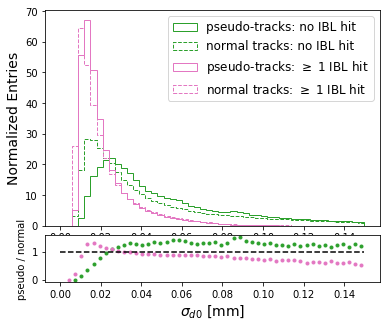

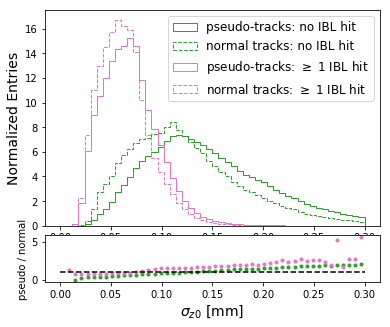

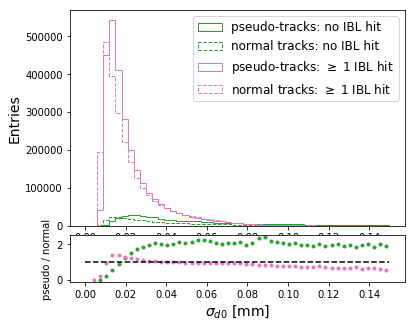

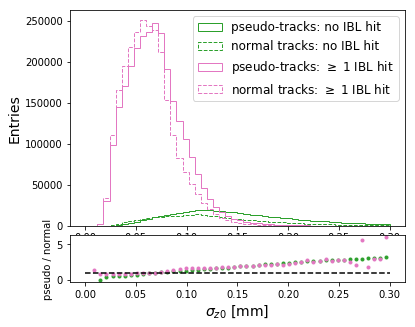

In [41]:
nBins = 50
for density,title_prefix in zip([True,False],['Normalized ','']):
    for IP, myRange in zip(['d0','z0'],[(0,0.15),(0,0.3)]):

        # Get the errors
        sigma_PT = txr_PT.loc[:,:,'ip3d_'+IP].values[mask_PT] / txr_PT.loc[:,:,'s'+IP].values[mask_PT]
        sigma_NT = txr_NT.loc[:,:,'ip3d_'+IP].values[mask_NT] / txr_NT.loc[:,:,'s'+IP].values[mask_NT]

        IBL_PT = txr_PT.loc[:,:,'nInnHits'].values[mask_PT]
        IBL_NT = txr_NT.loc[:,:,'nInnHits'].values[mask_NT]

        fig = plt.figure(figsize=(6,5))
        gs = gridspec.GridSpec(5,1)
        ax1 = fig.add_subplot(gs[:4,0])
        ax2 = fig.add_subplot(gs[4:,0])

        for mPT, mNT, label, c in zip([(IBL_PT == 0),(IBL_PT >= 1)], [(IBL_NT == 0),(IBL_NT >= 1)],
                                      ['no IBL hit','$\geq$ 1 IBL hit'],['C2','C6']):

            n_PT,edg,_ = ax1.hist(sigma_PT[mPT],
                                  bins=nBins,range=myRange,
                                  histtype='step', density=density, 
                                  color=c, linestyle='-',
                                  label='pseudo-tracks: '+label)
            n_NT,edg,_ = ax1.hist(sigma_NT[mNT],
                                  bins=nBins,range=myRange,
                                  histtype='step', density=density, 
                                  color=c, linestyle='--',
                                  label='normal tracks: '+label)

            ax2.plot(0.5 * (edg[:-1]+edg[1:]), n_PT / n_NT, 
                     color=c, marker='.', linewidth=0)

        ax1.legend(loc='upper right',fontsize=12)
        ax1.set_ylabel(title_prefix+'Entries',fontsize=14)

        ax2.set_xlabel(r'$\sigma_{'+IP+'}$ [mm]',fontsize=14)         
        ax2.set_ylabel('pseudo / normal')

        ax2.plot([edg[0],edg[-1]],[1]*2,'k--')

        plt.savefig('{}/{}_err_nInnHit{}.pdf'.format(figDir,IP,'_norm' if density else ''),bbox_inches='tight')
        
    plt.show()


**Only tracks with $P_{match} > 0.75$**

So, I was looking at some of the normalized distributions, and it was sometimes hard to disentangle the effects from the fakes in normal tracks versus the better tracking efficiency for pseudo-tracks.

So, PF suggested that I look at the same input distributions as before, but requiring $P_{match} > 0.75$, which I can do by requiring this origin variable is not equal to -1.


In [31]:
myVars = ['sd0', 'sz0', 'ip3d_d0', 'ip3d_z0', 'd0_err', 'z0_err',
          'ip3d_grade', 'pt', 'eta',  
          'nInnHits', 'nsharedBLHits', 'nsplitBLHits', 'nNextToInnHits', 
          'nPixHits', 'nPixHoles', 'nsharedPixHits', 'nsplitPixHits', 
          'nSCTHits', 'nSCTHoles', 'nsharedSCTHits', 'ptfrac', 'dr']

In [32]:
xlabels = ['$s_{d0}$', '$s_{z0}$', '$d_0$', r'$z_0 \sin (\theta)$', 
           '$\sigma_{d0}$', '$\sigma_{z0}$','IP3D grade', '$p_T$', '$\eta$', 
           'IBL hits', 'IBL shared hits', 'IBL split hits', 'PIX1 hits', 
           'pixel hits', 'pixel holes', 'shared pixel hits', 'split pixel hits',
           'SCT hits', 'SCT holes', 'shared SCT hits', '$p_T^{frac}$', '$\Delta R$']

var_bins = [50, 50, 50, 50, 50, 50, 
            14, 50, 50, 
            5, 5, 5, 5,
            10, 10, 10, 10,
            21, 10, 10, 50, 50]

var_ranges = [(-10,10), (-15,15), (-1,1), (-1.5,1.5), (0,0.3),(0,0.3),
              (-0.5,13.5), (0,100), (-2.5,2.5), 
              (-0.5,4.5), (-0.5,4.5), (-0.5,4.5), (-0.5,4.5),
              (-0.5,9.5), (-0.5,9.5), (-0.5,9.5), (-0.5,9.5),
              (-0.5,20.5), (-0.5,9.5), (-0.5,9.5), (0,0.5), (0, .4)]

In [33]:
# Also - some of the variables are categorical, so I'll want more descriptive xlabels 
ip3d_grades = ['No hits in first two layers; exp. hit in L0 and L1',
               'No hits in first two layers; exp. hit in L0 and no exp. hit in L1',
               'No hits in first two layers; no exp. hit in L0 and exp. hit in L1',
               'No hits in first two layers; no exp. hit in L0 and L1',
               'No hit in L0; exp hit in L0',
               'No hit in L0; no exp. hit in L0',
               'No hit in L1; exp hit in L1',
               'No hit in L1; no exp hit in L1',
               'Shared hit in both L0 and L1',
               'Shared pixel hits',
               'Two or more shared SCT hits',
               'Split hits in both L0 and L1',
               'Split pixel hit',
               'Good: a track not in any of the above categories']

In [34]:
orig_PT = txr_PT.loc[:,:,'orig'].values[mask_PT]
orig_NT = txr_NT.loc[:,:,'orig'].values[mask_NT]

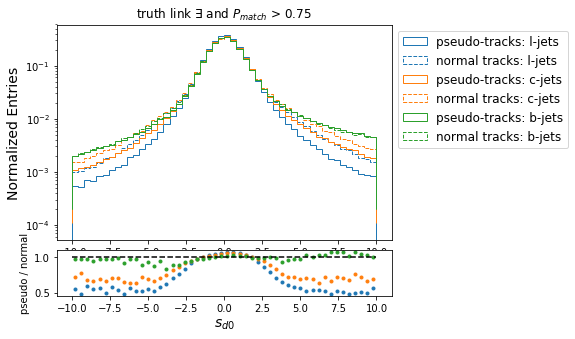

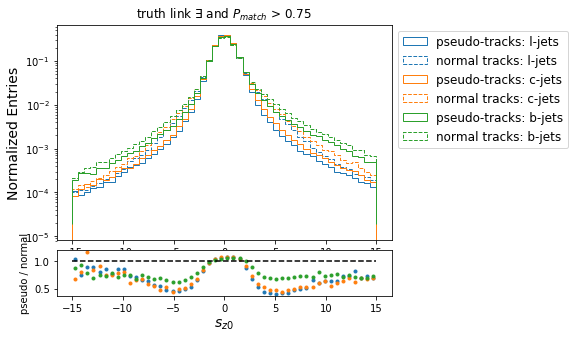

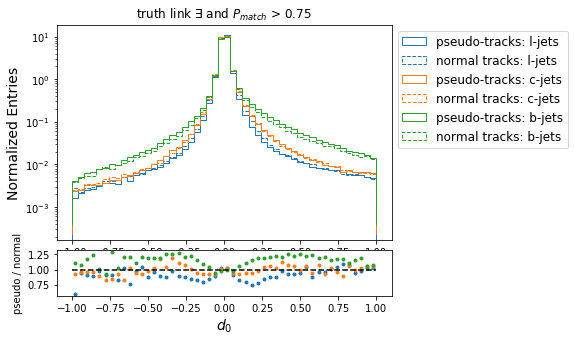

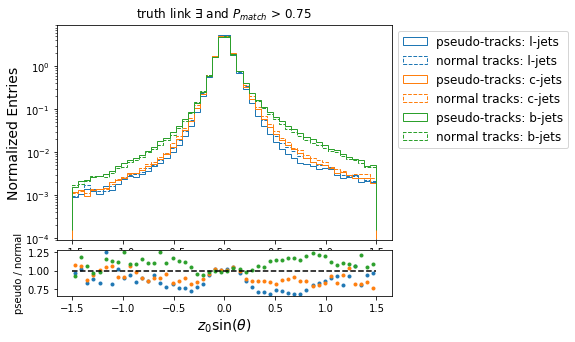

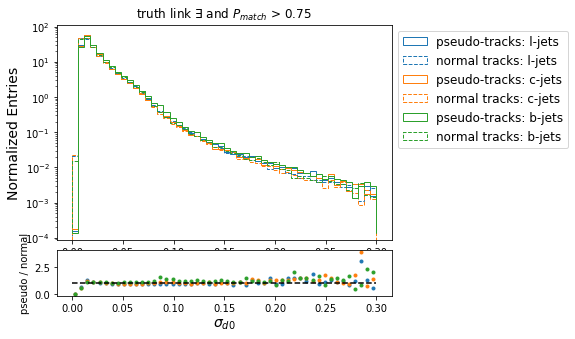

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


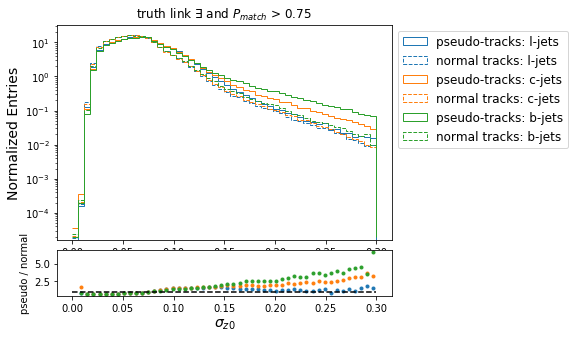

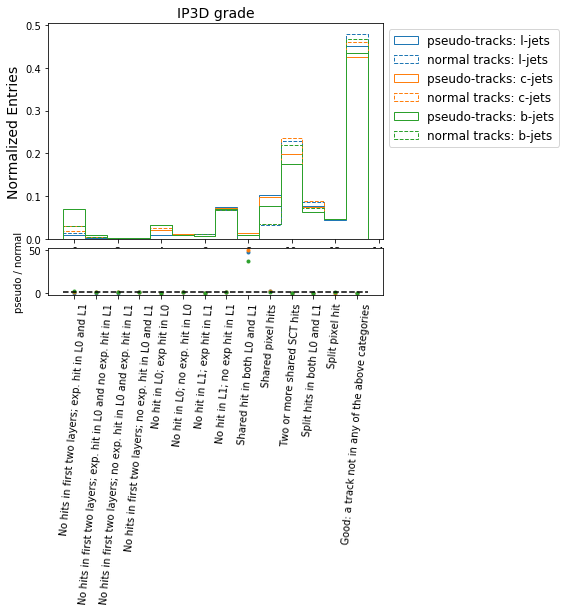

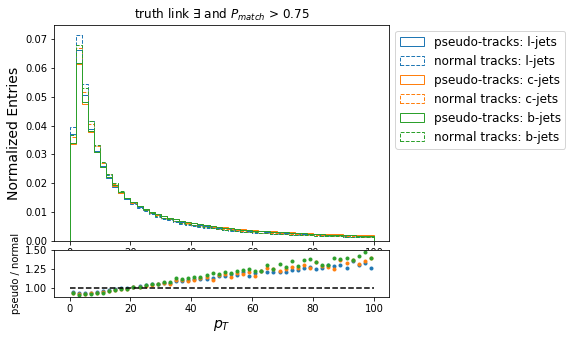

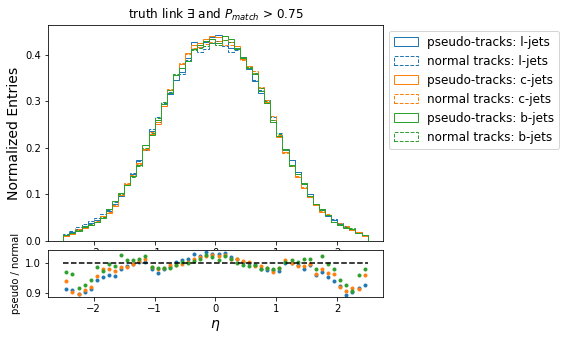

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


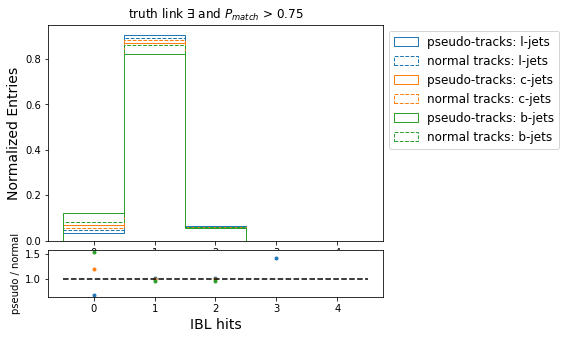

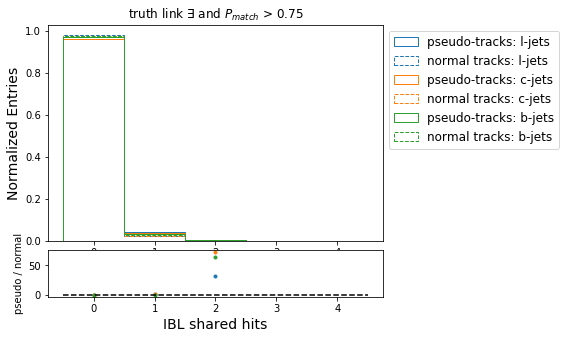

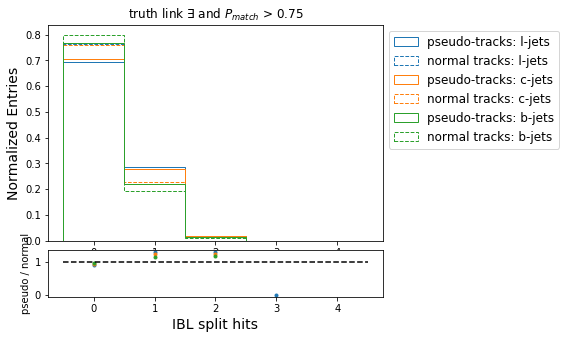

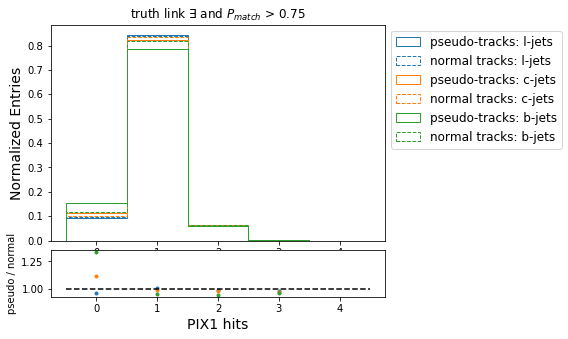

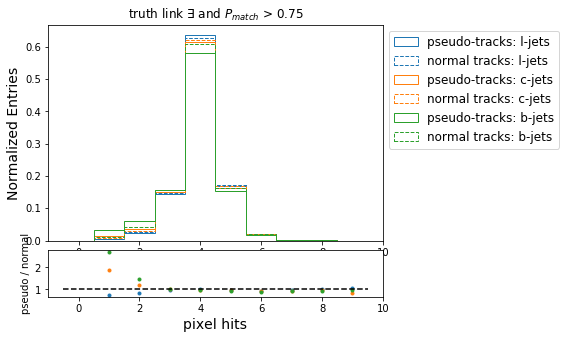

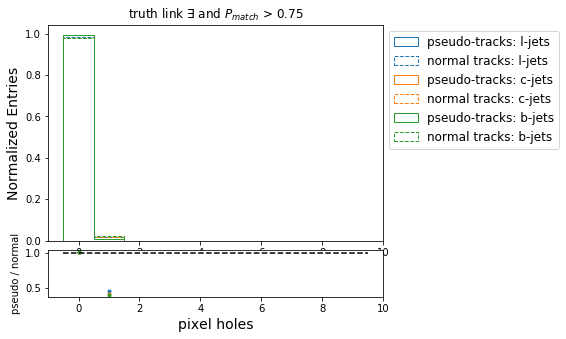

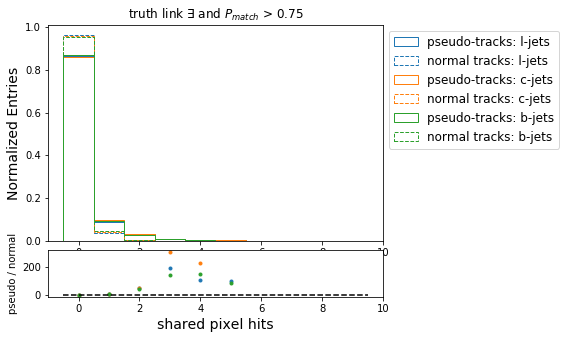

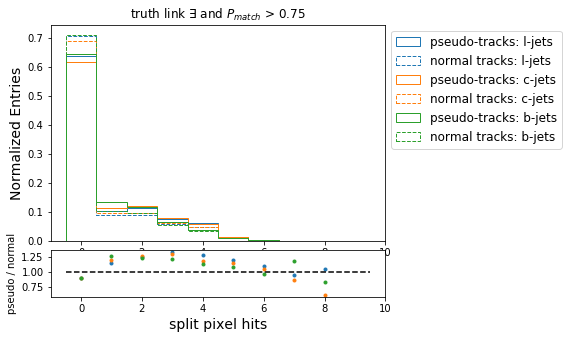

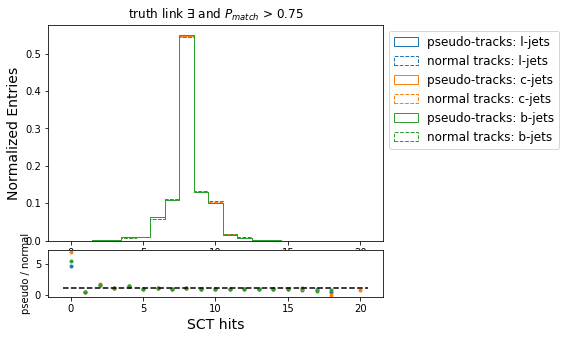

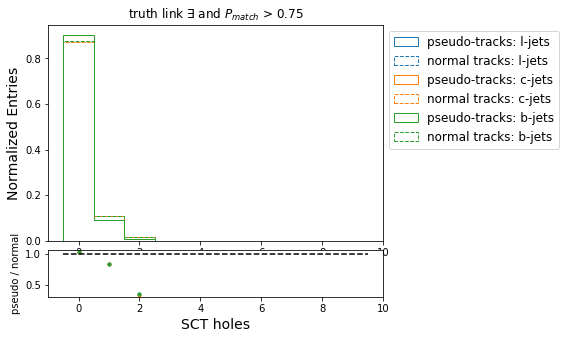

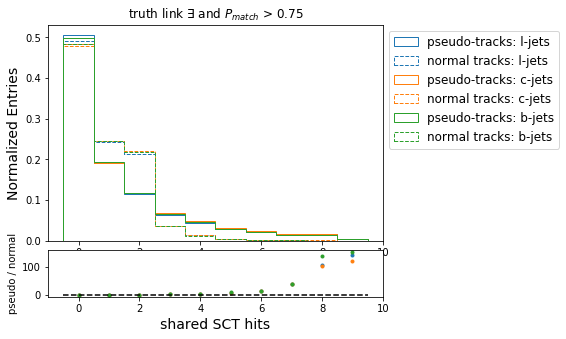

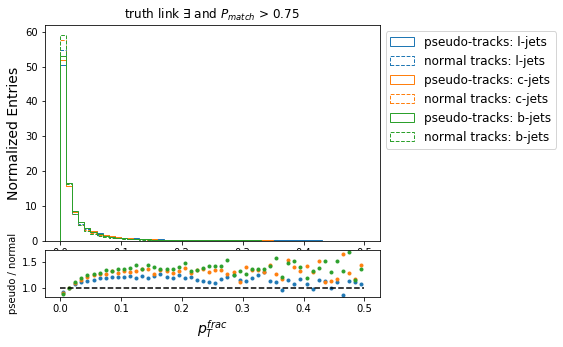

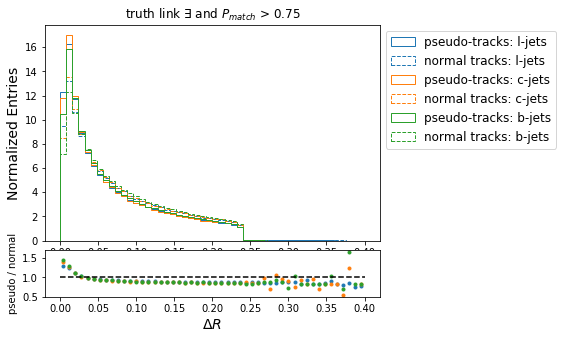

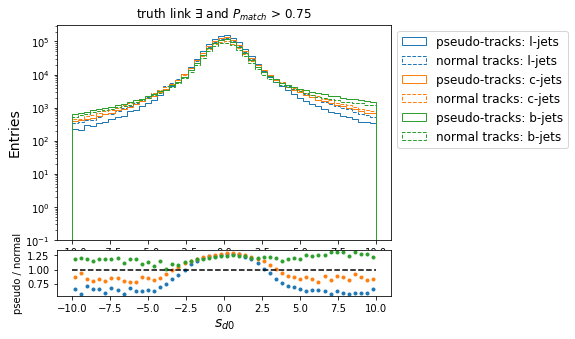

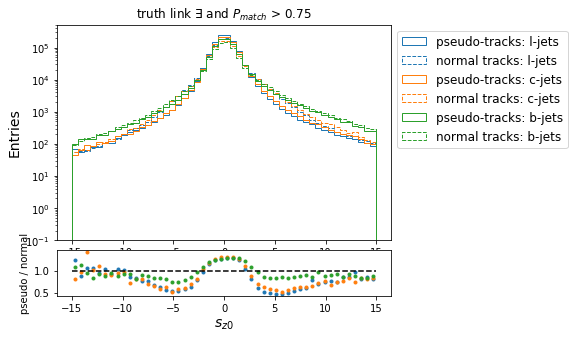

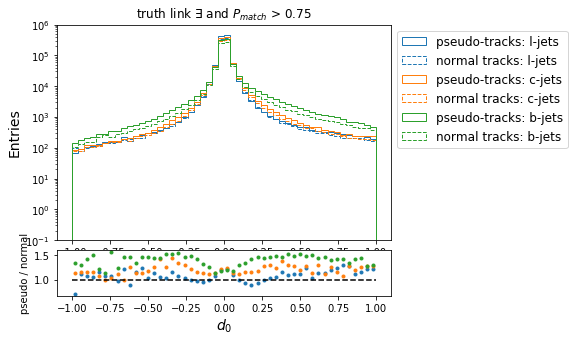

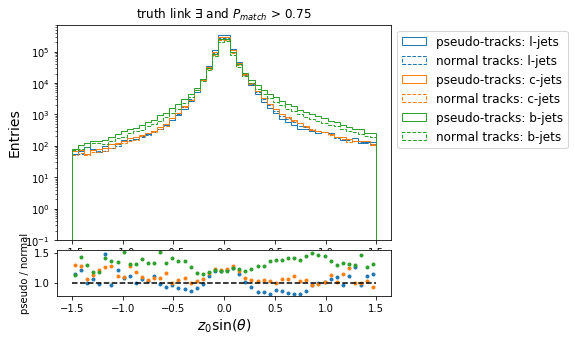

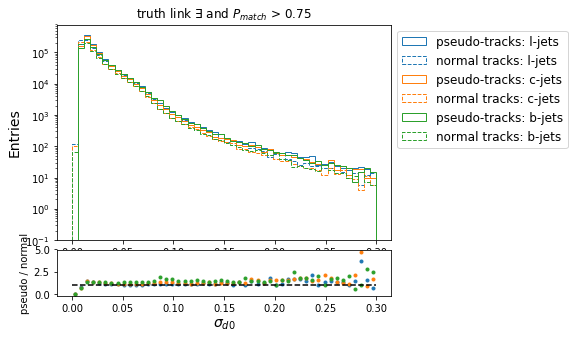

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


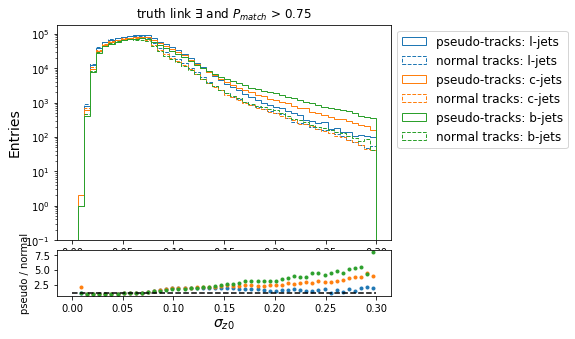

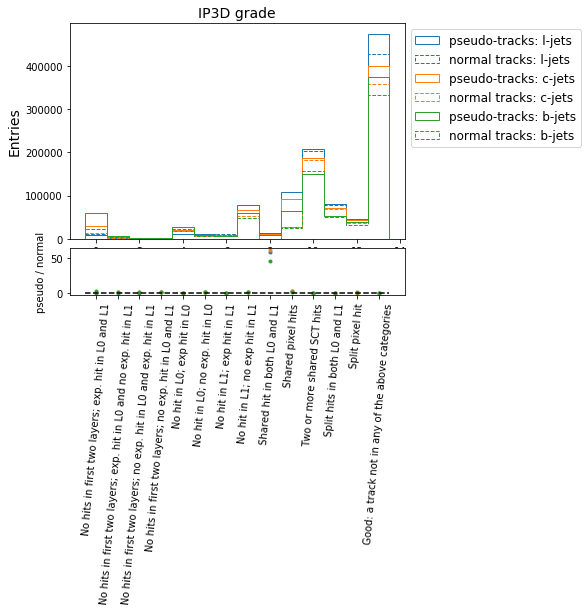

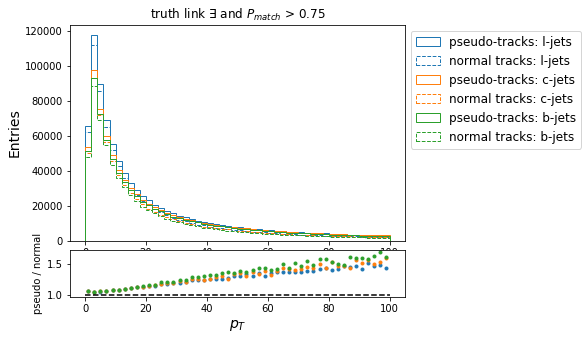

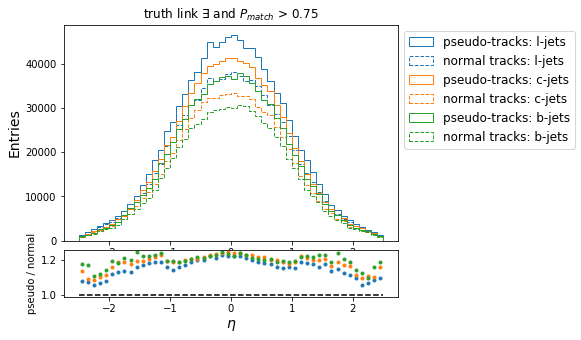

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


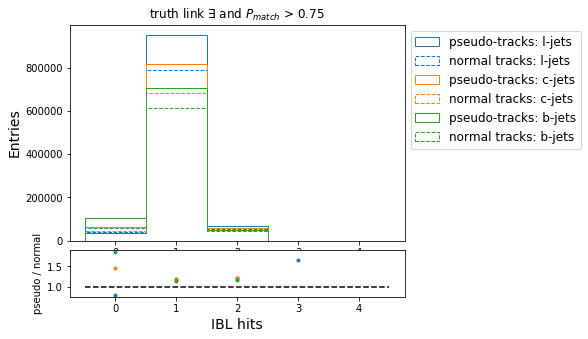

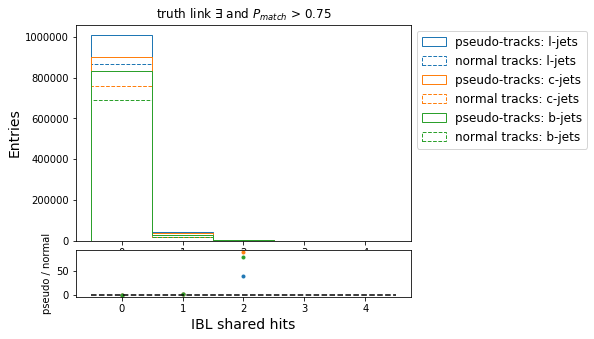

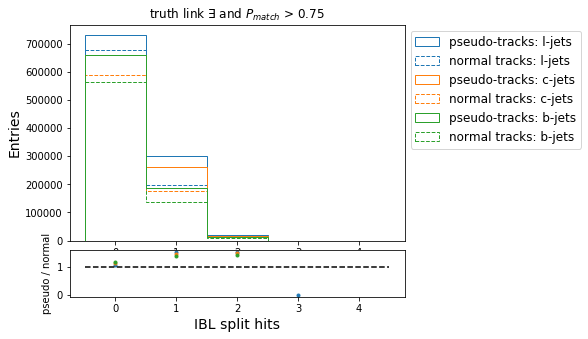

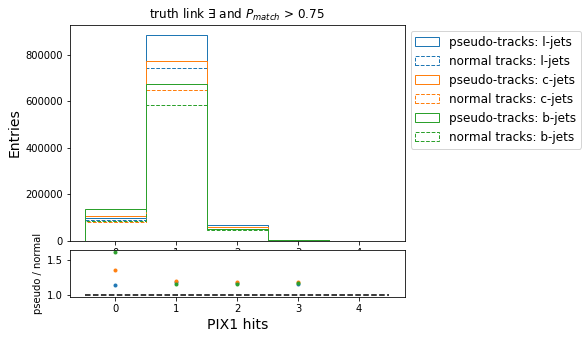

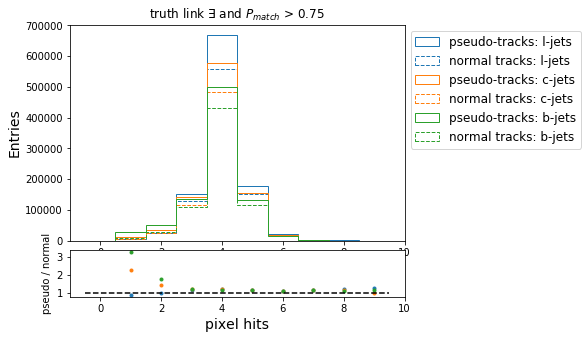

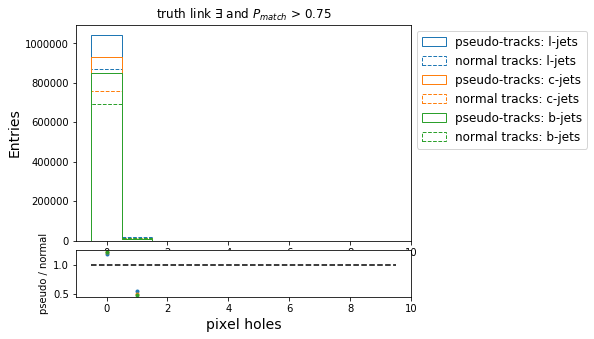

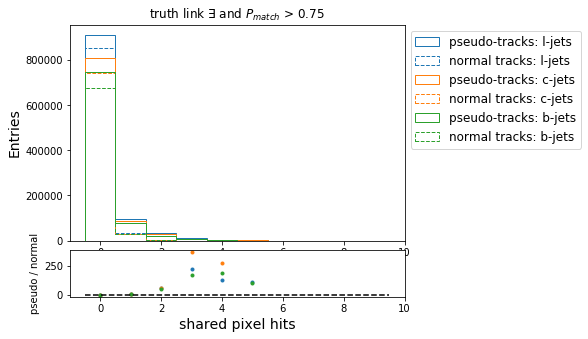

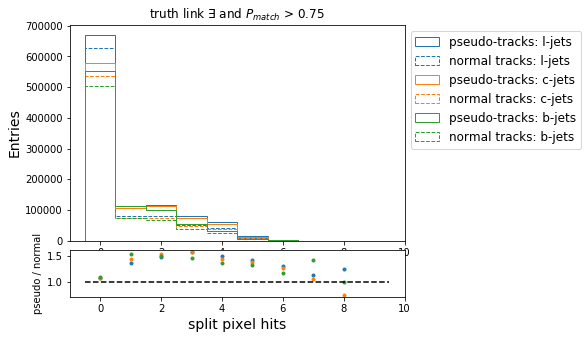

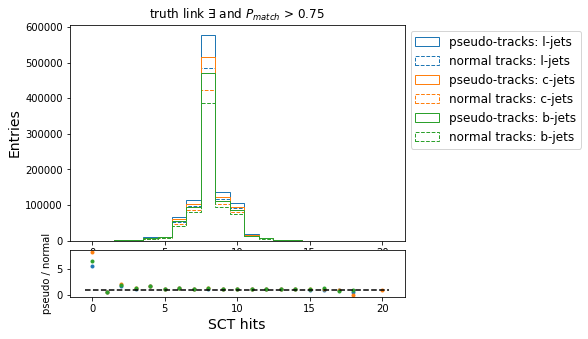

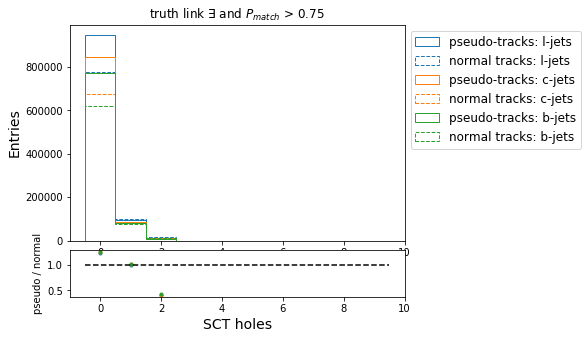

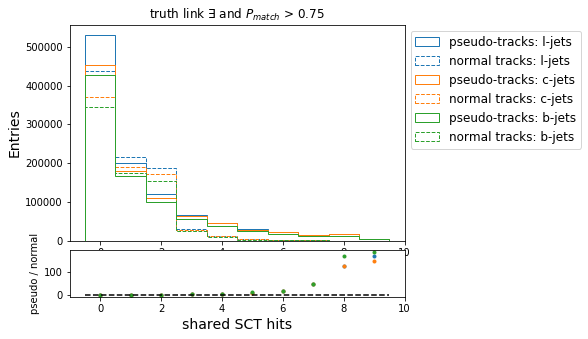

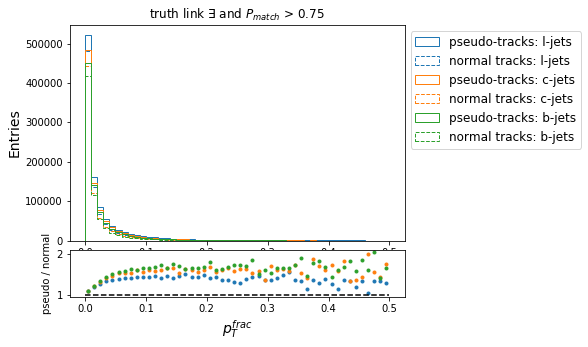

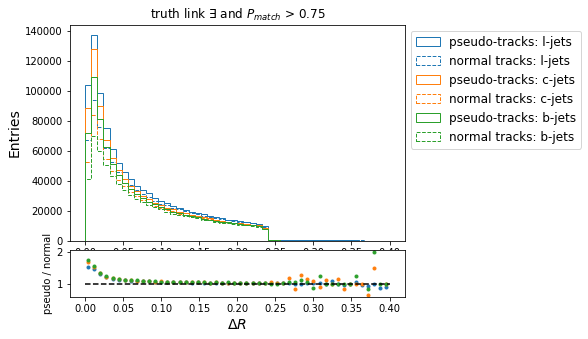

In [36]:
for density,title_prefix in zip([True,False],['Normalized ','']):

    for j, (tvar, xlabel, nBins, myRange) in enumerate(zip(myVars, xlabels, var_bins, var_ranges)):

        if 'err' not in tvar:
            var_PT = txr_PT.loc[:,:,tvar].values[mask_PT]
            var_NT = txr_NT.loc[:,:,tvar].values[mask_NT]
            
        else:
            IP = tvar[:2]
            var_PT = (txr_PT.loc[:,:,'ip3d_'+IP] / txr_PT.loc[:,:,'s'+IP]).values[mask_PT]
            var_NT = (txr_NT.loc[:,:,'ip3d_'+IP] / txr_NT.loc[:,:,'s'+IP]).values[mask_NT]
        
        # Normalize the IP distributions
        log = ( ('d0' in tvar) or ('z0' in tvar) )
            
        fig = plt.figure(figsize=(6,5))
        gs = gridspec.GridSpec(5,1)
        ax1 = fig.add_subplot(gs[:4,0])
        ax2 = fig.add_subplot(gs[4:,0])

        for yi, flav in zip(range(3), ['l','c','b']):

            c = 'C{}'.format(yi)

            n_PT,edg,_ = ax1.hist(var_PT[(ytrks_PT == yi) & (orig_PT != -1)],
                                  range=myRange,bins=nBins, histtype='step', 
                                  density=density, log=log,
                                  color=c, linestyle='-',
                                  label='pseudo-tracks: {}-jets'.format(flav))
            n_NT,edg,_ = ax1.hist(var_NT[(ytrks_NT == yi) & (orig_NT != -1)],
                                  range=myRange,bins=nBins,histtype='step', 
                                  density=density, log=log,
                                  color=c, linestyle='--',
                                  label='normal tracks: {}-jets'.format(flav))

            ax2.plot(0.5 * (edg[:-1]+edg[1:]), n_PT / n_NT, 
                     color=c, marker='.', linewidth=0)

        ax1.legend(bbox_to_anchor=(1,1),fontsize=12)
        ax1.set_ylabel(title_prefix+'Entries',fontsize=14)
        ax1.set_title('truth link $\exists$ and $P_{match}$ > 0.75')
        
        if tvar == 'ip3d_grade':
            ax2.set_xticks(0.5 * (edg[:-1]+edg[1:]))
            ax2.set_xticklabels(ip3d_grades,rotation=85)
            ax1.set_title(xlabel,fontsize=14)
        else:
            ax2.set_xlabel(xlabel,fontsize=14) 

        ax2.set_ylabel('pseudo / normal')

        ax2.plot([edg[0],edg[-1]],[1]*2,'k--')

        plt.savefig('{}/{}_noFakes{}.pdf'.format(figDir,tvar,'_norm' if density else ''),bbox_inches='tight')
        
        plt.show()